# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [54]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [55]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
#!wget -O data.tar.gz "{download_url}"
#!tar -xf data.tar.gz

In [56]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 0

In [57]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []

        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data['label'].values)))}
            self._idx_to_label = {idx: key for key, idx in labels.items()}
            self._classes = len(labels)
        else:
            self._classes = None  # Метки отсутствуют для тестового набора

        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        waveform = waveform.to(DEVICE)  # Ensure waveform is on the correct device
        feats = self._feats(waveform)[0]
        return feats, self._labels[index]

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        if self._classes is None:
            raise ValueError("This dataset does not contain labels.")
        return self._classes

def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [58]:
# Try to use LogMelSpectrogram or MFCC to achive better score
class LogMelSpectrogram(nn.Module):
    def __init__(self, n_mels=40, sample_rate=16000, n_fft=400, hop_length=160, f_min=0.0, f_max=None):
        """
        Преобразование входного аудиосигнала в логарифмическую мел-спектрограмму.

        :param n_mels: Количество мел-фильтров.
        :param sample_rate: Частота дискретизации входного сигнала.
        :param n_fft: Количество точек для вычисления FFT.
        :param hop_length: Шаг окна.
        :param f_min: Минимальная частота для мел-фильтров.
        :param f_max: Максимальная частота для мел-фильтров. Если None, берется половина частоты дискретизации.
        """
        super(LogMelSpectrogram, self).__init__()
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            f_min=f_min,
            f_max=f_max if f_max else sample_rate // 2
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB(stype='power')

    def forward(self, waveform):
        """
        Прямой проход через слой.

        :param waveform: Входной аудиосигнал (формат [1, samples]).
        :return: Логарифмическая мел-спектрограмма.
        """
        mel_spec = self.mel_spec(waveform)  # Вычисляем мел-спектрограмму
        log_mel_spec = self.amplitude_to_db(mel_spec)  # Преобразуем в логарифмическую шкалу
        return log_mel_spec

# FBANK 40 by default, but you can choose something else
FEATS = 40
transform = LogMelSpectrogram(n_mels=FEATS).to(DEVICE)
trainset = Dataset('train', 'ml_trains_data', transform, read_labels=True)
testset = Dataset('eval', 'ml_trains_data', transform, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

Augmentation

In [59]:
def augment_waveform(waveform, sample_rate=16000):
    if torch.rand(1).item() < 0.5:
        waveform += 0.005 * torch.randn_like(waveform)  # Добавление шума
    if torch.rand(1).item() < 0.5:
        waveform = torchaudio.transforms.TimeStretch()(waveform)
    if torch.rand(1).item() < 0.5:
        waveform = torchaudio.transforms.PitchShift(sample_rate, n_steps=2)(waveform)
    return waveform


### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [60]:
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    class_accuracies = []
    for c in range(classes):
        tp = sum((y == c and p == c) for y, p in items)
        total = sum((y == c) for y, _ in items)
        if total == 0:
            continue
        class_accuracies.append(tp / total)
    return sum(class_accuracies) / len(class_accuracies)


In [61]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [62]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        X = X.to(DEVICE)  # Ensure the batch data is on the correct device
        Y = Y.to(DEVICE)  # Ensure the targets are on the correct device
        pred = model.forward(X)
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze())
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.cpu().data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)

# Modify the `train` function to call `stage`
def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 10,
):
    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')

In [63]:
class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_dim, 64, kernel_size=5, stride=1, padding=2),  # Слой 1
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # Пулинг для уменьшения размерности

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),  # Слой 2
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),  # Слой 3
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Сжимаем до фиксированной длины
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),  # Полносвязный слой
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out_dim)  # Классификация
        )

    def forward(self, X):
        x = self.conv_layers(X)
        return self.fc(x)


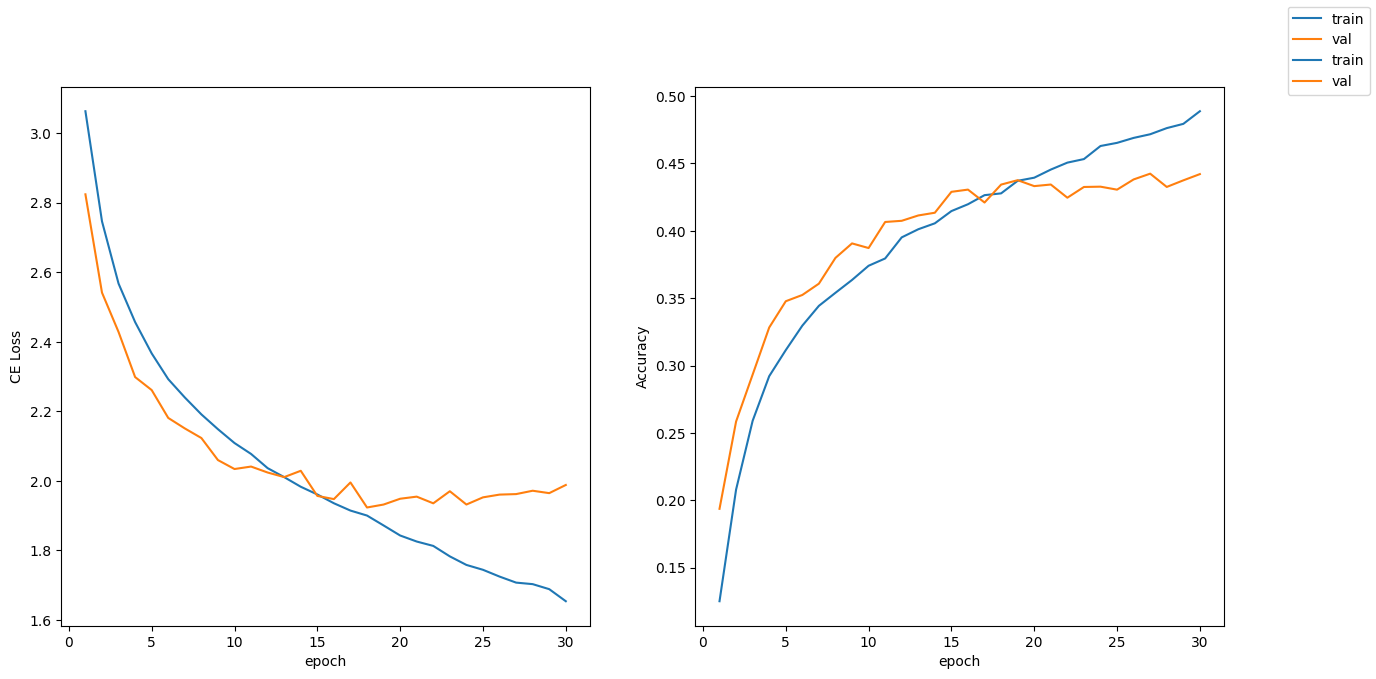

Epoch 30.
Train loss 1.6538257514881247. Train accuracy 0.48880413946394197.
Test loss 1.9880759803260244. Test accuracy 0.44212214168391845


In [64]:
# Move the model to the correct device (GPU or CPU)
model = Model().to(DEVICE)

# Define the optimizer for training
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Train the model (moving data to device within the train function)
train(model, opt, batch_size=64, epochs=30)


### Prediction part

Prepare result file and send it to Yandex.Contest

In [65]:
# Prediction part (ensure that features are also moved to the correct device)
result = []
for idx, ytid in enumerate(testset._ytids):
    feats, _ = testset[idx]  # Load features for the test sample
    feats = feats.to(DEVICE)  # Move features to the correct device

    # Reshape and pass through the model
    predict = torch.argmax(model.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()

    # Append the prediction and YTID to the results
    result.append((ytid, trainset._idx_to_label[predict]))

# Save the results to a CSV file
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)

In [66]:
from google.colab import files
files.download('result.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>